# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [88]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [119]:
df = brfss.ReadBrfss(nrows=None)

The following function selects a random subset of a `DataFrame`.

In [120]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [121]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

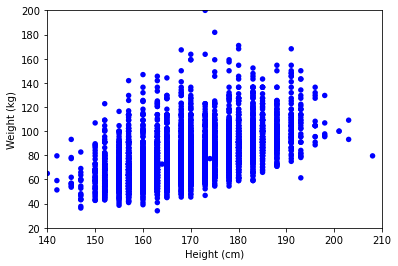

In [122]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noice to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [123]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4.

In [124]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

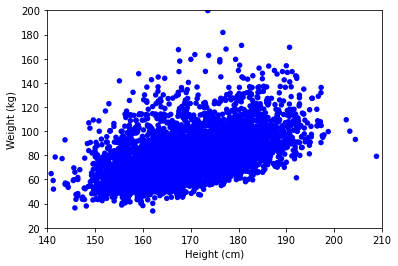

In [125]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

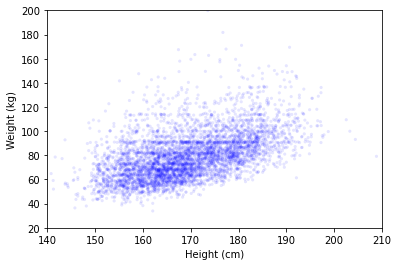

In [126]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

# An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

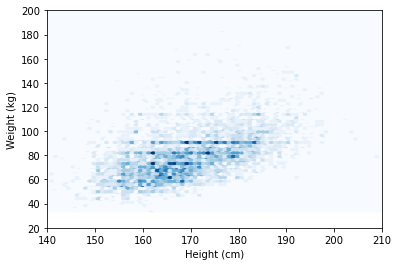

In [127]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

# **Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatterplot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

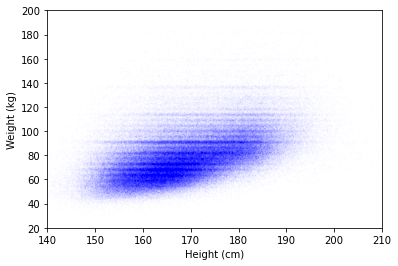

In [128]:
# With smaller markers, I needed more aggressive jittering to
# blur the measurement artifacts

# With this dataset, using all of the rows might be more trouble
# than it's worth.  Visualizing a subset of the data might be
# more practical and more effective.

heights = Jitter(df.htm3, 2.8)
weights = Jitter(df.wtkg2, 1.0)

thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [129]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [130]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [131]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [132]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

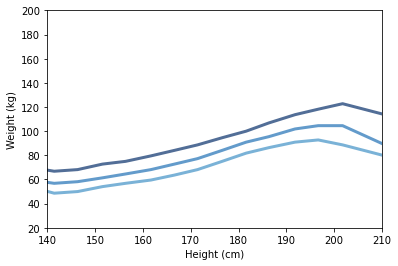

In [133]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

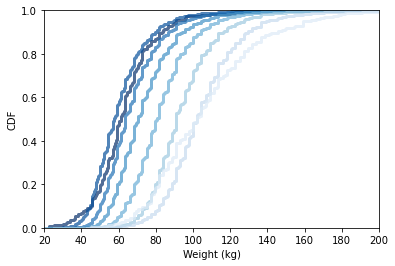

In [134]:
bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [135]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [136]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.3329085769776

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [137]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [138]:
Corr(heights, weights)

0.5087364789734607

NumPy provides a function that computes correlations, too:

In [139]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [155]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [156]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [157]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [158]:
SpearmanCorr(heights, weights)

0.5405846262320491

# An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [159]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983452

# Exercises

# Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [182]:
import first
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [193]:
# getting ages, Weights from life
ages_x = live.agepreg
weights_y = live.totalwgt_lb
# Passing the Ages, Weights to Corr Function ( xs,ys) to determine the Correlation between both of them
print ("The Correlation between Ages and Weights is :")
print(Corr(ages_x, weights_y))

# Passing the Ages, Weights to SpearmanCorr Function ( xs,ys) to determine the Correlation between both of them (method :spearman)
print ("The Correlation between Ages and Weights by using spearman method is :")
print(SpearmanCorr(ages, weights))

The Correlation between Ages and Weights is :
0.06883397035410908
The Correlation between Ages and Weights by using spearman method is :
0.0020914571012349815


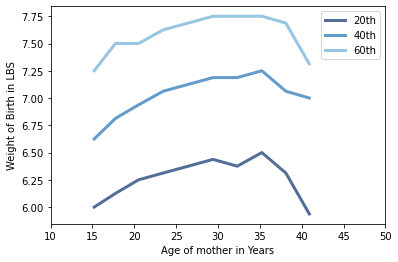

In [194]:
# Source - Ref 1

def BinPerc(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    # numpy.arange interval - 10, 48 with 3
    bin = np.arange(10, 48, 3)
   
    # indices - numpy.digitized - Source - Ref 3
    indices = np.digitize(df.agepreg, bin)
    #groups by using Pandas Dataframe - combine
    groups = df.groupby(indices)
    # ages
    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    #cdf as per previous function
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]
    
    #using the previous plot code
    
    thinkplot.PrePlot(3)
    for percent in [20,40,60]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Age of mother in Years",
                     ylabel='Weight of Birth in LBS',
                     xlim=[10, 50], legend=True)
    
BinPerc(live)

# Conclusions:
    
1.  The Correlation between Ages and Weights is : 0.06883397035410908
    The Correlation between Ages and Weights by using spearman method is : 0.09461004109658226
        The default Correlation method is Pearson.So perason's is 0.07 and Spearman's is around 0.09
        This shows that outliers exists. Also its having non-linear.
        
2.  The percentile plot shows that birth weight increases up to 25 with fast phase. Then decreasing or slower increase.


# References 
1. https://stackoverflow.com/questions/39308146/calculating-percentile-of-bins-from-numpy-digitize
2. https://numpy.org/doc/stable/reference/generated/numpy.arange.html
3. https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.digitize.html

In [ ]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import brfss

import thinkstats2
import thinkplot

# The estimation game

In [ ]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

In [ ]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

# Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [ ]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

In [ ]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

# The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [ ]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

In [ ]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

# The mean of the sample means is close to the actual value of $\mu$.

In [ ]:
np.mean(xbars)

In [ ]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

In [ ]:
stderr = RMSE(xbars, 90)
stderr

# Estimating rates

The following function simulates experiments where we try to estimate the mean of an exponential distribution using the mean and median of a sample.

In [ ]:
def Estimate3(n=7, iters=1000):
    lam = 2

    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        means.append(L)
        medians.append(Lm)

    print('rmse L', RMSE(means, lam))
    print('rmse Lm', RMSE(medians, lam))
    print('mean error L', MeanError(means, lam))
    print('mean error Lm', MeanError(medians, lam))
    
Estimate3()

# **Exercise 8.1 Page No. 99:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [197]:
# Based on the Estimation related excerise
def Estimate4(n=7, iters=100000):
    
    """Mean error for xbar and median as estimators of population mean.
    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1
    # mean and median arrays
    means = []
    medians = []
    
    # adding both median and Mean into 
    for _ in range(iters):
        xValues = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xValues)
        median = np.median(xValues)
        means.append(xbar)
        medians.append(median)

    print ("mean Error for Xbar is : ")
    print(MeanError(means, mu))
    print ("mean Error for median is : ")
    print(MeanError(medians, mu))
#continue after Estimate 3 
Estimate4()

mean Error for Xbar is : 
-0.00114836987292322
mean Error for median is : 
-0.0007857951558944469


In [196]:
# Based on the Estimation related excerise

def Estimate5(n=7, iters=100000):
    """RMSE for biased and unbiased estimators of population variance.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('RMSE biased value as below : ')
    print(RMSE(estimates1, sigma**2))
    print('RMSE unbiased value as below : ')
    print(RMSE(estimates2, sigma**2))
    
#continue after Estimate 4
Estimate5()

RMSE biased value as below : 
0.513718768736429
RMSE unbiased value as below : 
0.5763643850644057


# Conclusion:

# 1) xbar and median are lower mean error as m increases, so Its biased


# 2) The biased estimator (0.52) is less than the unbiased estimator (0.58). 

# **Exercise 8.2 Page No. 99:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



standard error 0.7784467549145117
confidence interval (1.2845593898220162, 3.7403879421508535)


0.7784467549145117

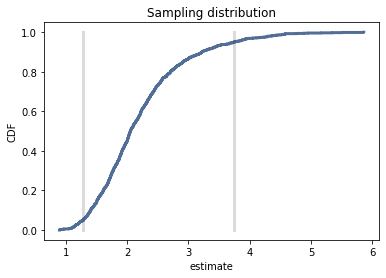

In [195]:
# plot based on the cdf. folowed from the excercise file
# as per excercise n=10,  λ=2, 1000 times iterations

def SimulateSample(lam=2, n=10, iterations=1000):
    
    def VertLine(x, y=1):
        thinkplot.Plot([x, x], [0, y], color='0.8', linewidth=3)

    estimates = []
    for _ in range(iterations):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print('standard error', stderr)

    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print('confidence interval', ci)
    VertLine(ci[0])
    VertLine(ci[1])

    # plot the CDF
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='estimate',
                     ylabel='CDF',
                     title='Sampling distribution')

    return stderr

SimulateSample()